# Financial and Economic Data Applications
Original from Wes McKinney (https://github.com/wesm/pydata-book/tree/1st-edition)

Updated and edited for Python circa 2018 by R. D. Slater

MSDS 7333 - Quantifying the World - Case Study 8  
Signal Frontier Analysis  
Team Members: Jeffery Lancon, Manisha Pednekar, Andrew Walch, David Stroud  
Date: 03/05/2019


In [1]:
from __future__ import division
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 6))

In [2]:
%matplotlib inline

In [3]:
import os
currentDir = %pwd
os.chdir(currentDir)

In [4]:
pwd

'C:\\Users\\Prodigy\\Documents\\GitRepositories\\MSDS_7333_QTW\\CaseStudy_8'

## Signal frontier analysis

### Balanced Portfolio
LOW - Lowes Home Improvement  
SBUX - Starbucks  
FB - Facebook  
JNJ - Johnson & Johnson  
BAC - Bank of America Corporation  
GE - General Electric

In [5]:
import datetime
import pandas as pd

start_dt=datetime.datetime(2016,1,4)
end_dt=datetime.datetime(2019,2,27)
from pandas_datareader import data as web
#stock='AAPL'
#px=pd.DataFrame({'AAPL':web.get_data_yahoo(stock, start_dt, end_dt)['Adj Close']})
#names=['GOOG','MSFT', 'GS','INTC', 'MS', 'BAC', 'C']
stock='LOW'
px=pd.DataFrame({'LOW':web.get_data_yahoo(stock, start_dt, end_dt)['Adj Close']})
names=['SBUX','FB','JNJ','BAC', 'GE']
for stock in names:
    while True:
        try:
            px[stock]=web.get_data_yahoo(stock, start_dt, end_dt)['Adj Close']
            break
        except:
            print('Unable to read stock: {0}'.format(stock))
            print('trying again')


In [6]:
#px = pd.read_csv('ch11/stock_px.csv')

In [7]:
plt.close('all')

Text(0.5,1,'Cumulative Returns since Jan 2016 - Balanced Portfolio')

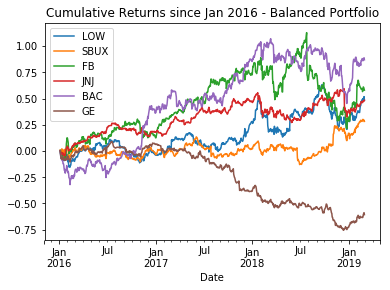

In [8]:
px = px.asfreq('B').fillna(method='pad')
rets = px.pct_change()
((1 + rets).cumprod() - 1).plot()
plt.title('Cumulative Returns since Jan 2016 - Balanced Portfolio')

In [9]:
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

In [10]:
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)

    daily_rets = prices.pct_change()

    # Compute portfolio returns
    port = port.shift(1).resample(freq).first()
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1)

    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [11]:
strat_sr(px, 70, 30)

-0.6168993173332457

In [12]:
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(px, lb, hold)

ddf = DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [13]:
import matplotlib.pyplot as plt
def heatmap(df, portfolio,cmap=plt.get_cmap('seismic')):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    ax.set_title("Heatmap - {} Portfolio (Sharpe Ratios)".format(portfolio))
    plt.colorbar(axim)

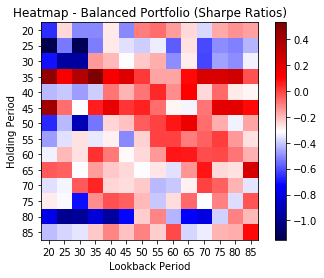

In [14]:
heatmap(ddf,'Balanced')
plt.show()

In [15]:
# max for each row
maxForRow = ddf.max(axis=0)
globalMax = maxForRow.max()
# https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole/46934204
print('\x1b[4;1;34m'+'Portfolio - Balanced'+'\x1b[0m')
print ("Max Sharpe Ratio is: %f" % globalMax)
ddf[ddf.values==globalMax]

Portfolio - Balanced
Max Sharpe Ratio is: 0.531893


Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
35,0.470675,0.127008,0.360404,0.531893,0.13059,0.219423,0.018617,-0.158685,-0.162956,0.094631,0.232003,0.232232,0.265808,-0.021976


In [16]:
# min for each row
minForRow = ddf.min(axis=0)
globalMin = minForRow.min()
print('\x1b[4;1;34m'+'Portfolio - Balanced'+'\x1b[0m')
print ("Min Sharpe Ratio is: %f" % globalMin)
ddf[ddf.values==globalMin]

Portfolio - Balanced
Min Sharpe Ratio is: -1.150454


Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
25,-1.150454,-0.528491,-1.119628,-0.521761,-0.271035,-0.358118,-0.389374,-0.336403,-0.572981,-0.262194,-0.606345,-0.499148,-0.517218,-0.432639


---

### Financial Services Portfolio
JPM - JP Morgan Chase  
GS - Goldman Sachs  
BAC - Bank of America  
CME - CME Group  
MS - Morgan Stanley  
USB - US Bancorp

In [17]:
stock='JPM'
pxFin=pd.DataFrame({stock:web.get_data_yahoo(stock, start_dt, end_dt)['Adj Close']})
namesFin=['GS', 'BAC','CME', 'MS', 'USB']
for stock in namesFin:
    while True:
        try:
            pxFin[stock]=web.get_data_yahoo(stock, start_dt, end_dt)['Adj Close']
            break
        except:
            print('Unable to read stock: {0}'.format(stock))
            print('trying again')

Text(0.5,1,'Cumulative Returns since Jan 2016 - Financial Services Portfolio')

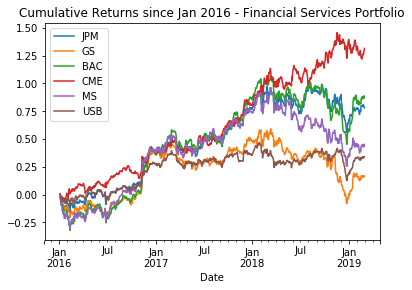

In [18]:
plt.close('all')
pxFin = pxFin.asfreq('B').fillna(method='pad')
rets = pxFin.pct_change()
((1 + rets).cumprod() - 1).plot()
plt.title('Cumulative Returns since Jan 2016 - Financial Services Portfolio')

In [19]:
strat_sr(pxFin, 70, 30)

-0.9858895528083693

In [20]:
lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
ddFin = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        ddFin[lb][hold] = strat_sr(pxFin, lb, hold)

ddfFin = DataFrame(ddFin)
ddfFin.index.name = 'Holding Period'
ddfFin.columns.name = 'Lookback Period'

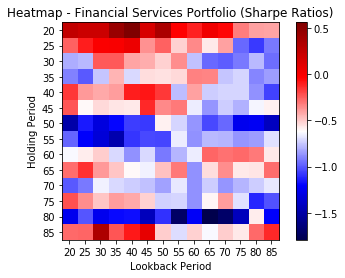

In [21]:
heatmap(ddfFin,'Financial Services')
plt.show()

In [22]:
# max for each row
maxForRow = ddfFin.max(axis=0)
globalMax = maxForRow.max()
print('\x1b[4;1;34m'+'Portfolio - Financial'+'\x1b[0m')
print ("Max Sharpe Ratio is: %f" % globalMax)
ddfFin[ddfFin.values==globalMax]

Portfolio - Financial
Max Sharpe Ratio is: 0.562195


Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
20,0.258585,0.206699,0.207492,0.435937,0.562195,0.155338,0.353965,-0.027018,-0.10904,0.036753,-0.039767,-0.319948,-0.399932,-0.41154


In [23]:
# min for each row
minForRow = ddfFin.min(axis=0)
globalMin = minForRow.min()
print('\x1b[4;1;34m'+'Portfolio - Financial'+'\x1b[0m')
print ("Min Sharpe Ratio is: %f" % globalMin)
ddfFin[ddfFin.values==globalMin]

Portfolio - Financial
Min Sharpe Ratio is: -1.793080


Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
80,-1.256922,-1.005073,-1.252891,-1.181078,-1.168751,-1.423793,-1.093195,-1.70845,-1.231726,-1.79308,-1.693519,-1.417127,-0.570134,-1.204596


---

### Technology Portfolio
INTC - Intel Corporation  
AAPL - Apple  
GOOGL - Alphabet Inc Class A - Google  
FB - Facebook  
IBM - International Business Machine  
ADBE - Adobe Inc.

In [24]:
stock='INTC'
pxTech=pd.DataFrame({stock:web.get_data_yahoo(stock, start_dt, end_dt)['Adj Close']})
namesTech=['AAPL', 'GOOGL','FB', 'IBM', 'ADBE']
for stock in namesTech:
    while True:
        try:
            pxTech[stock]=web.get_data_yahoo(stock, start_dt, end_dt)['Adj Close']
            break
        except:
            print('Unable to read stock: {0}'.format(stock))
            print('trying again')

Text(0.5,1,'Cumulative Returns since Jan 2016 - Technology Portfolio')

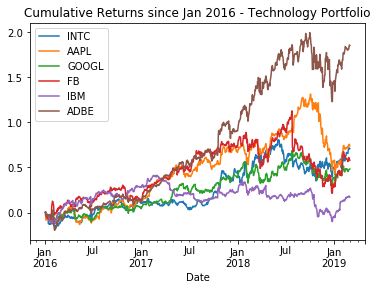

In [25]:
plt.close('all')
pxTech = pxTech.asfreq('B').fillna(method='pad')
rets = pxTech.pct_change()
((1 + rets).cumprod() - 1).plot()
plt.title('Cumulative Returns since Jan 2016 - Technology Portfolio')

In [26]:
strat_sr(pxTech, 70, 30)

-0.0745311376826402

In [27]:
lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
ddTech = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        ddTech[lb][hold] = strat_sr(pxTech, lb, hold)

ddfTech = DataFrame(ddTech)
ddfTech.index.name = 'Holding Period'
ddfTech.columns.name = 'Lookback Period'

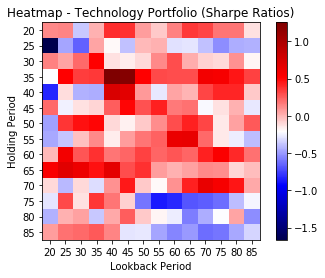

In [28]:
heatmap(ddfTech,'Technology')
plt.show()

In [29]:
# max for each row
maxForRow = ddfTech.max(axis=0)
globalMax = maxForRow.max()
print('\x1b[4;1;34m'+'Portfolio - Technology'+'\x1b[0m')
print ("Max Sharpe Ratio is: %f" % globalMax)
ddfTech[ddfTech.values==globalMax]

Portfolio - Technology
Max Sharpe Ratio is: 1.254416


Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
35,-0.211546,0.515282,0.352075,0.363577,1.254416,1.220158,0.518301,0.3196,0.301601,0.30021,0.589753,0.565703,0.460925,0.33904


In [30]:
# min for each row
minForRow = ddfTech.min(axis=0)
globalMin = minForRow.min()
print('\x1b[4;1;34m'+'Portfolio - Technology'+'\x1b[0m')
print ("Min Sharpe Ratio is: %f" % globalMin)
ddfTech[ddfTech.values==globalMin]

Portfolio - Technology
Min Sharpe Ratio is: -1.663423


Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
25,-1.663423,-0.456591,-0.653295,0.052139,-0.186554,-0.382255,-0.004155,0.020961,-0.284472,-0.273734,-0.384447,-0.534143,-0.439635,-0.426686
